In [2]:
# initial set-up
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *

from Adam import Adam
from sewar.full_ref import rmse, uqi
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

torch.manual_seed(0)
np.random.seed(0)

c:\Users\azhir\anaconda3\envs\gundam\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#  CONFIGURATIONS - HYPER PARAMETERS
################################################################
#  configurations - HYPER PARAMETERS
################################################################
epochs = 20
batch_size = 10
learning_rate = 0.001

epochs = 20
step_size = 50
gamma = 0.5

width = 64

weight_decay=1e-4

# Hyperparameters to change - epoch{10,100,200}, step_size{}, batchsize{}, gamma{}, modes{}, weight_decay{}

In [4]:
class CNN_1(nn.Module):
    def __init__(self):
        super(CNN_1, self).__init__()
       
        self.fc0 = nn.Linear(64, 256)

        self.conv1 = nn.Conv2d(1, 128, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(128, 1, kernel_size=1, stride=1, padding=0)
        #self.conv3 = nn.Conv2d(32, 3, kernel_size=5, stride=1, padding=5//2),
    def forward(self, x):
       
        x = self.fc0(x)
        x = x.reshape(x.shape[0],1,16,16)

        x = self.conv1(x)
        x = F.relu(x)

        x = self.conv2(x)        
        x = F.sigmoid(x)
        return x




class CNN_2(nn.Module):
    def __init__(self):
        super(CNN_2, self).__init__()
       
        self.fc0 = nn.Linear(1, 16)

        self.cnn0 = nn.Conv2d(8, 128, 5)

        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128,2) 

    def forward(self, x):
       
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        x = self.cnn0(x)
        x = F.relu(x)

        x = self.fc1(x)
        x = self.fc2(x)        
        return x



class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        #Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, 
                              out_channels=16,
                             kernel_size=5,
                             stride=1,
                             padding=2)
        self.relu1 = nn.ReLU()
        # Max Pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        #Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, 
                              out_channels=32,
                             kernel_size=5,
                             stride=1,
                             padding=2)
        self.relu2 = nn.ReLU()
        # Max Pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
                
        self.fc1 = nn.Linear(32*7*7, 2)
    
    def forward(self, x):
        x = x.permute(0, 3, 1, 2)

        # C1
        out = self.cnn1(x)
        out = self.relu1(out)
        
        #Maxpool1
        out = self.maxpool1(out)
        
        #c1
        out = self.cnn2(out)
        out = self.relu2(out)
        
        #Maxpool1
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        #Linear Function
        
        x = x.permute(0, 2, 3, 1)
        out = self.fc1(out)

        out = out.reshape(x.shape[0],1,16,16)

        #Output 
        #return F.log_softmax(out,dim=1)
        return out 


class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
            
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [5]:
# DATA LOADING
############################## DATA LOADING ########################################
raw_data = scipy.io.loadmat('./datasets/final_data')

sol = np.asarray(raw_data['solution_data'])
mes = np.asarray(raw_data['measurement_data'])


def convert_data(data_x, data_y):
    data_X = torch.from_numpy(data_x).float()
    data_Y = torch.from_numpy(data_y).float()
    return data_X, data_Y

# we are solving the inverse problem, so going from measurements, to solutions
X, y = convert_data(mes, sol)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ntrain = X_train.shape[0]
ntest = X_test.shape[0]

X_dim = X_train.shape[1]
y_dim = y_train.shape[1]

X_train = X_train.reshape(ntrain,1,X_dim)
X_test = X_test.reshape(ntest,1,X_dim)

y_train = y_train.reshape(ntrain,1,16,16)
y_test = y_test.reshape(ntest,1,16,16)

train_dataset = TensorDataset( X_train, y_train )
test_dataset = TensorDataset( X_test, y_test )

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('training data: measurements', X_train.shape, 'solution', y_train.shape)
print('training data: measurements', X_test.shape, 'solution', y_test.shape)

training data: measurements torch.Size([8000, 1, 64]) solution torch.Size([8000, 1, 16, 16])
training data: measurements torch.Size([2000, 1, 64]) solution torch.Size([2000, 1, 16, 16])


C:\Users\azhir\AppData\Local\Temp\ipykernel_29436\1690142048.py:10: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Copy.cpp:239.)
  data_X = torch.from_numpy(data_x).float()


In [6]:
# MODEL METRICS
###################################
# MODEL METRICS
###################################
def model_metrics(model,test_loader,ntrain):
    rms_values, psnr_values, ssim_values, uqi_values = [], [], [], []

    for test_num in range(ntest):
        K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
        model.eval()

        predicted_np = np.reshape(model(K).detach().cpu().numpy(),(16,16))

        truth = test_loader.dataset[test_num][1]
        truth_np = np.reshape(truth.numpy(),(16,16))

        #diff_image = predicted - truth_np
        #np.sqrt(np.sum(diff_image**2)/256)

        rms_values.append(rmse(predicted_np, truth_np))
        psnr_values.append(psnr(truth_np, predicted_np, data_range=predicted_np.max() - predicted_np.min()))
        ssim_values.append(ssim(truth_np, predicted_np, data_range=predicted_np.max() - predicted_np.min()))
        uqi_values.append(uqi(predicted_np, truth_np))

    model_rms = sum(rms_values)/ len(rms_values)
    std_rms = np.std(np.array(rms_values))

    model_psnr = sum(psnr_values)/ len(psnr_values)
    std_psnr = np.std(np.array(psnr_values))

    model_ssim = sum(ssim_values)/ len(ssim_values)
    std_ssim = np.std(np.array(ssim_values))

    model_uqi = sum(uqi_values)/ len(uqi_values)
    std_uqi = np.std(np.array(uqi_values))


    print("RMSE: ", round(model_rms,5), round(std_rms,5), sep="---")
    print("PSNR: ", round(model_psnr,5), round(std_psnr,5), sep="---")
    print("SSIM: ", round(model_ssim,5), round(std_ssim,5), sep="---")
    #print("UQI: ", model_uqi, std_uqi, sep="---")


    output = {
    "rms": rms_values,
    "psnr": psnr_values,
    "ssim": ssim_values,
    "uqi": uqi_values,
    # average values
    'model_rms': [model_rms,std_rms],
    'model_psnr': [model_psnr,std_psnr],
    'model_ssim': [model_ssim,std_ssim]
    }
    return output 

In [7]:
# TRAINING AND EVALUATION
################################################################
# TRAINING AND EVALUATION
################################################################


def train_model(model, epochs, batch_size, learning_rate, weight_decay, step_size, gamma):
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    train_losses, test_losses, epoch_time = [], [], []

    myloss = LpLoss(size_average=False)
    for ep in range(epochs):
        model.train()
        t1 = default_timer()
        train_mse = 0
        train_l2 = 0
        total_time = 0
        for x, y in train_loader:
            x, y = x.cuda(), y.cuda()

            optimizer.zero_grad()
            #print('in: ',x.shape)
            out = model(x)
            #print('out: ',out.shape)

            mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
            l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
            l2.backward() # use the l2 relative loss

            optimizer.step()
            train_mse += mse.item()
            train_l2 += l2.item()

        scheduler.step()
        model.eval()
        test_l2 = 0.0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.cuda(), y.cuda()

                out = model(x)
                test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

        #train_mse /= len(train_loader)
        train_l2 /= ntrain
        train_losses.append(train_l2)
        test_l2 /= ntest
        test_losses.append(test_l2)


        t2 = default_timer()
        epoch_time.append(t2 - t1)

        print(ep, t2 - t1, train_l2, test_l2)
    total_time = sum(epoch_time)
    print("TOTAL TIME: ", total_time, sep="---")

    output = {
    "train_losses": train_losses,
    "test_losses": test_losses,
    "epoch_time": epoch_time,
    "training_time": total_time,
    "model": model
    }
    return output 

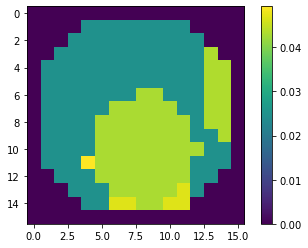

In [8]:
#Actual
test_num = 434
truth_out = test_loader.dataset[test_num][1]
plt.imshow(np.reshape(truth_out.numpy(),(16,16)))
plt.colorbar()

c:\Users\azhir\anaconda3\envs\gundam\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 6.891064999974333 0.7253216618001461 0.2643354343771934
1 2.3510928000323474 0.2394146531522274 0.20252969682216646
2 2.348911799956113 0.20456989689171315 0.21704939329624176
3 2.340457299957052 0.1885648288577795 0.21015006494522095
4 2.3638669999781996 0.17801872593164444 0.18670438504219056
5 2.370814700028859 0.16864402540028095 0.16127094769477845
6 2.2822093999711797 0.16351191505789756 0.15675262409448623
7 2.4118649000301957 0.15603062200546264 0.15005148285627365
8 2.3382708999561146 0.15250522011518478 0.14660456371307373
9 2.3051752999890596 0.1486014964133501 0.14026258105039596
10 2.2980830000014976 0.14540253522992133 0.13741924867033958
11 2.3397157000144944 0.14300626304745673 0.15602109491825103
12 2.2805473000044003 0.1415008355304599 0.14177771872282027
13 2.2875195000087842 0.1396050970852375 0.1344684471786022
14 2.2741953999502584 0.13784533490240575 0.1349910061955452
15 2.351549100014381 0.1366789481267333 0.1348559471964836
16 2.3066173000261188 0.1354592185

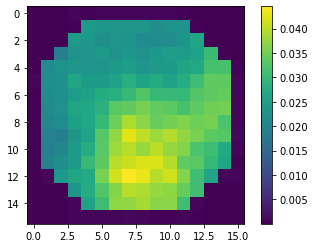

In [9]:
# SIGMA - TEST NETWORK
############################################################################

model_fcn_sigma = CNN_1().cuda()
output_sigma = train_model(model_fcn_sigma, epochs, batch_size, learning_rate, weight_decay, step_size, gamma)

output_sigma_model = output_sigma.get("model")
#torch.save(output_1L_model, 'fno2D_1l.h5')
results_sigma = model_metrics(output_sigma_model,test_loader,ntrain)

# TEST NETWORK RESULTS
############################################################################
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
output_sigma_model.eval()
predicted = np.reshape(output_sigma_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

In [10]:
count_params(CNN_1().cuda())

20097

In [9]:
for param in output_sigma_model.parameters():
    

SyntaxError: incomplete input (4258999843.py, line 2)

In [ ]:
print(output_sigma_model.conv1.weight.detach().cpu().numpy())

plt.imshow(output_sigma_model.conv1.weight.detach().cpu().numpy()[100,0,:,:])
plt.colorbar()


In [ ]:
plt.imshow(output_sigma_model.conv1.weight.detach().cpu().numpy()[11,0,:,:])


In [ ]:
plt.imshow(output_sigma_model.conv2.weight.detach().cpu().numpy()[0,0,:,:])
plt.colorbar()


## No Activation at Output \
TOTAL TIME: ---60.02260470003239 \
RMSE: ---0.0037127026052949028---0.0013857613394051892 \
PSNR: ---22.69011644693345---2.028075345982437 \
SSIM: ---0.8060126236254511---0.04646556360044524 \
UQI: ---0.9899743358159191---0.0055662495667199675 \


# Sigmoid Activation at Output \
TOTAL TIME: ---51.887425200111466 \
RMSE: ---0.0034470120599841055---0.0015170417002827185 \
PSNR: ---23.428421555266524---2.6392534576879516 \
SSIM: ---0.8059130948960732---0.04777352207116035 \
UQI: ---0.9906065019419129---0.0066035246963146174 \



# Analaysis for Model

In [ ]:
# Models
#############################################################################
model = model_fcn_sigma
results =  results_sigma

In [ ]:
metric_type = 'ssim'         # can be the following rms, ssim, psnr

fig1, ax1 = plt.subplots()
red_cross = dict(markerfacecolor='r', marker='x')
data = (results.get(metric_type))

ax1.boxplot(data, vert=False, flierprops=red_cross)
plt.xlabel(metric_type)
plt.show

In [ ]:
# Create outlier range
q75, q25 = np.percentile(data, [75 ,25])
iqr = q75 - q25
outliers = [q25-1.5*iqr,q75+1.5*iqr]

# zip data
data_no = range(len(data))
listed_data = zip(data_no,data)

data_list = list(listed_data)



print('outliers are anything below ',outliers[0],' or above ',outliers[1])

outlier_list = []
for i in range(len(data)):
    if data_list[i][1] < outliers[0]:
        outlier_list.append(data_list[i])
    elif data_list[i][1] > outliers[1]:
        outlier_list.append(data_list[i])


In [ ]:
print('the number of outliers are ',len(outlier_list) )
#worst reconstruction
worst = [np.min(np.asarray(outlier_list)[:,1]), np.max(np.asarray(outlier_list)[:,1]) ]
print('for outliers, the lowest metric value is ',worst[0],' and highest is', worst[1])

# The values for the worst performers! 
for i in range(len(outlier_list)):
    if outlier_list[i][1] ==  worst[0]:
        print(outlier_list[i])
    elif outlier_list[i][1] == worst[1]:
        print(outlier_list[i])


In [ ]:
print(outlier_list)

In [ ]:
#Actual
name = 'ccn_'
test_num = 1504

truth_out = test_loader.dataset[test_num][1]
plt.imshow(np.reshape(truth_out.numpy(),(16,16)))
plt.colorbar()


save_truth = name + metric_type + str(test_num)
#plt.savefig('./images/'+save_truth)

In [ ]:
# Quickly showing that our model gives expected results. 
model.eval()
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
predicted = np.reshape(model(K).detach().cpu().numpy(),(16,16))

plt.imshow(predicted)
plt.colorbar()

save_recon = save_truth + '_recon'
plt.savefig('./images/' + save_recon)

In [ ]:
test_num = 12

truth_out = test_loader.dataset[test_num][1]
plt.imshow(np.reshape(truth_out.numpy(),(16,16)))
plt.colorbar()

print(truth_out.shape)

In [ ]:
temp = np.reshape(truth_out.numpy(),(16,16))
zoom = temp[2:5,12:15]

plt.imshow(zoom)
plt.colorbar()

In [ ]:
zoom_list = [(2,5,5,8),(2,5,12,15),(5,8,8,1),(6,9,2,5)]

In [ ]:
original = np.reshape(truth_out.numpy(),(16,16))

index = zoom_list[1]

original_box = original[index[0]:index[1],index[2]:index[3]]


plt.imshow(original_box)
plt.colorbar()

In [ ]:
model.eval()
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
recon = np.reshape(model(K).detach().cpu().numpy(),(16,16))

recon_box = recon[index[0]:index[1],index[2]:index[3]]

plt.imshow(recon_box)
plt.colorbar()

# TEST STUFF OUT 

In [ ]:
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))